<a href="https://colab.research.google.com/github/aniskhan25/kaggle/blob/main/playground_series_S03E22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Predict Health Outcomes of Horses**

##**Playground Series - Season 3, Episode 22**

The dataset for this competition (both train and test) was generated from a deep learning model trained on a portion of the Horse Survival Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os

import numpy as np
import pandas as pd

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [ ]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
project_name = 'PS-S03E22'

path = os.path.join(os.getcwd(), 'drive/MyDrive/DATA', project_name)

train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))
origin = pd.read_csv(os.path.join(path, 'horse.csv'))

# Combine both original and training data
train = pd.concat([train, origin], ignore_index=True)

train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0.0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1.0,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2.0,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3.0,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4.0,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [ ]:
print(train.dtypes)

id                       float64
surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
outcome                   object
dtype: object


In [ ]:
# Feature transformations
def clean_and_transform(df):
    # change 3 to more_3_sec
    df['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)
    # convert slight and moderate to mild pain category
    df['pain'].replace({'slight': 'mild_pain'}, inplace=True)
    df['pain'].replace({'moderate': 'mild_pain'}, inplace=True)
    # clean below 3 columns
    df['peristalsis'].replace({'distend_small': np.nan}, inplace=True)
    df['nasogastric_reflux'].replace({'slight': np.nan}, inplace=True)
    df['rectal_exam_feces'].replace({'serosanguious': np.nan}, inplace=True)

#     df['rectal_temp'] = abs(df['rectal_temp'] - 37.8)
#     df['pulse_resp'] = df['pulse']*df['respiratory_rate']
#     df['pulse'] = abs(df['pulse'] - 60)
#     df['protein'] = df['total_protein']/df['abdomo_protein']
#     df['total_protein_cat'] = df['total_protein'] > 40
    df['lesion_1'] = df['lesion_1'].astype('str')
    df['lesion1'] = df['lesion_1'].apply(lambda x: x+'0'*(4-len(x)) if len(x) <= 4 else x)
    df['lesion_site'] = df['lesion1'].apply(lambda x: x[:2] if len(x) == 5 and x[0] == '1' else x[0])
    df['lesion_type'] = df['lesion1'].apply(lambda x: x[2] if len(x) == 5 and x[0] == '1' else x[1])
    df['lesion_subtype'] = df['lesion1'].apply(lambda x: x[3] if len(x) == 5 and x[0] == '1' else x[2])
    df['lesion_code'] = df['lesion1'].apply(lambda x: x[-2:] if len(x) == 5 and x[0] != '1' else x[-1])
    df.lesion_type.replace({'7': '0'}, inplace=True)
    df = df.drop(['id', 'lesion1', 'lesion_1', 'lesion_2', 'lesion_3'], axis=1)
    return df

train = clean_and_transform(train)
test = clean_and_transform(test)

train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,cp_data,outcome,lesion_site,lesion_type,lesion_subtype,lesion_code
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,8.5,serosanguious,3.4,yes,no,died,2,2,0,9
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,64.0,serosanguious,2.0,yes,no,euthanized,2,2,0,8
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,6.4,serosanguious,3.4,yes,no,lived,5,1,2,4
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,7.0,cloudy,3.9,yes,yes,lived,2,2,0,8
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,7.3,cloudy,2.6,no,yes,lived,0,0,0,0


In [ ]:
def encode_cat(df):
  le = LabelEncoder()

  df['surgery'] = le.fit_transform(df['surgery'])
  df['age'] = le.fit_transform(df['age'])
  df['temp_of_extremities'] = le.fit_transform(df['temp_of_extremities'])
  df['peripheral_pulse'] = le.fit_transform(df['peripheral_pulse'])
  df['mucous_membrane'] = le.fit_transform(df['mucous_membrane'])
  df['capillary_refill_time'] = le.fit_transform(df['capillary_refill_time'])
  df['pain'] = le.fit_transform(df['pain'])
  df['peristalsis'] = le.fit_transform(df['peristalsis'])
  df['abdominal_distention'] = le.fit_transform(df['abdominal_distention'])
  df['nasogastric_tube'] = le.fit_transform(df['nasogastric_tube'])
  df['nasogastric_reflux'] = le.fit_transform(df['nasogastric_reflux'])
  df['rectal_exam_feces'] = le.fit_transform(df['rectal_exam_feces'])
  df['abdomen'] = le.fit_transform(df['abdomen'])
  df['abdomo_appearance'] = le.fit_transform(df['abdomo_appearance'])
  df['surgical_lesion'] = le.fit_transform(df['surgical_lesion'])
  df['cp_data'] = le.fit_transform(df['cp_data'])
  #df['outcome'] = le.fit_transform(df['outcome'])
  df['lesion_site'] = le.fit_transform(df['lesion_site'])
  df['lesion_type'] = le.fit_transform(df['lesion_type'])
  df['lesion_subtype'] = le.fit_transform(df['lesion_subtype'])
  df['lesion_code'] = le.fit_transform(df['lesion_code'])

  return df

train = encode_cat(train)
test = encode_cat(test)

train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,cp_data,outcome,lesion_site,lesion_type,lesion_subtype,lesion_code
0,1,0,530001,38.1,132.0,24.0,2,4,3,2,...,8.5,3,3.4,1,0,died,4,2,0,10
1,1,0,533836,37.5,88.0,12.0,2,3,5,2,...,64.0,3,2.0,1,0,euthanized,4,2,0,9
2,1,0,529812,38.3,120.0,28.0,2,4,6,1,...,6.4,3,3.4,1,0,lived,7,1,2,5
3,1,0,5262541,37.1,72.0,30.0,1,4,6,2,...,7.0,2,3.9,1,1,lived,4,2,0,9
4,0,0,5299629,38.0,52.0,48.0,3,3,4,1,...,7.3,2,2.6,0,1,lived,0,0,0,0


In [ ]:
# Replace categorical missing values with mode
def impute_cat(df):
    for col in df.select_dtypes('object').columns:
        mode = df[col].mode().values[0]
        df[col] = df[col].fillna(mode)
    return df

# Impute numerical missing values with KNN imputer
def impute_numeric(df):
    imputer = KNNImputer()
    numeric_cols = df.select_dtypes('number').columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    return df

#train = impute_cat(train)
#test = impute_cat(test)

#train = impute_numeric(train)
#test = impute_numeric(test)

In [ ]:
# Sanity check for missing values
train.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp               60
pulse                     24
respiratory_rate          58
temp_of_extremities        0
peripheral_pulse           0
mucous_membrane            0
capillary_refill_time      0
pain                       0
peristalsis                0
abdominal_distention       0
nasogastric_tube           0
nasogastric_reflux         0
nasogastric_reflux_ph    246
rectal_exam_feces          0
abdomen                    0
packed_cell_volume        29
total_protein             33
abdomo_appearance          0
abdomo_protein           198
surgical_lesion            0
cp_data                    0
outcome                    0
lesion_site                0
lesion_type                0
lesion_subtype             0
lesion_code                0
dtype: int64

In [ ]:
target_map={
    "lived":0,
    "died": 1,
    "euthanized":2
}

X = train.loc[:, train.columns != 'outcome']
y = train['outcome']

classes = np.unique(y)  # Get unique class labels
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_numeric = np.array([class_to_index[cls] for cls in y])

X.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,cp_data,lesion_site,lesion_type,lesion_subtype,lesion_code
0,1,0,530001,38.1,132.0,24.0,2,4,3,2,...,57.0,8.5,3,3.4,1,0,4,2,0,10
1,1,0,533836,37.5,88.0,12.0,2,3,5,2,...,33.0,64.0,3,2.0,1,0,4,2,0,9
2,1,0,529812,38.3,120.0,28.0,2,4,6,1,...,37.0,6.4,3,3.4,1,0,7,1,2,5
3,1,0,5262541,37.1,72.0,30.0,1,4,6,2,...,53.0,7.0,2,3.9,1,1,4,2,0,9
4,0,0,5299629,38.0,52.0,48.0,3,3,4,1,...,47.0,7.3,2,2.6,0,1,0,0,0,0


In [ ]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",tree_method='hist',
    #class_weight=class_weights_dict,
    random_state=42, eval_metric="merror"
    )

params = {
    "colsample_bytree": uniform(0.7, 0.1),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 200), # default 100
    "subsample": uniform(0.6, 0.4),
    #'eval_metric': 'merror',
    'objective': 'multi:softmax',
    #'tree_method': 'hist',
    #'class_weight': class_weights_dict
    #'class_weight':['balanced', class_weights_dict]
}

search = RandomizedSearchCV(xgb_model
                            , param_distributions=params, random_state=42
                            , n_iter=200, cv=3
                            , verbose=0, n_jobs=-1
                            , return_train_score=True)

search.fit(X, y_numeric)

report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.746 (std: 0.023)
Parameters: {'colsample_bytree': 0.7501039883915259, 'gamma': 0.26968872420003126, 'learning_rate': 0.23518913081944232, 'max_depth': 5, 'n_estimators': 123, 'objective': 's', 'subsample': 0.977700638850067}



In [ ]:
tuned_xgb = search.best_estimator_

preds = tuned_xgb.predict(test)

In [ ]:
sub = pd.read_csv(os.path.join(path, 'sample_submission.csv'))
sub['outcome'] = preds
sub['outcome'] = sub['outcome'].map({0: 'died', 1: 'euthanized', 2: 'lived'})
sub.to_csv('horse_submission.csv', index=False)

In [ ]:
sub

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived
...,...,...
819,2054,died
820,2055,euthanized
821,2056,died
822,2057,lived


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

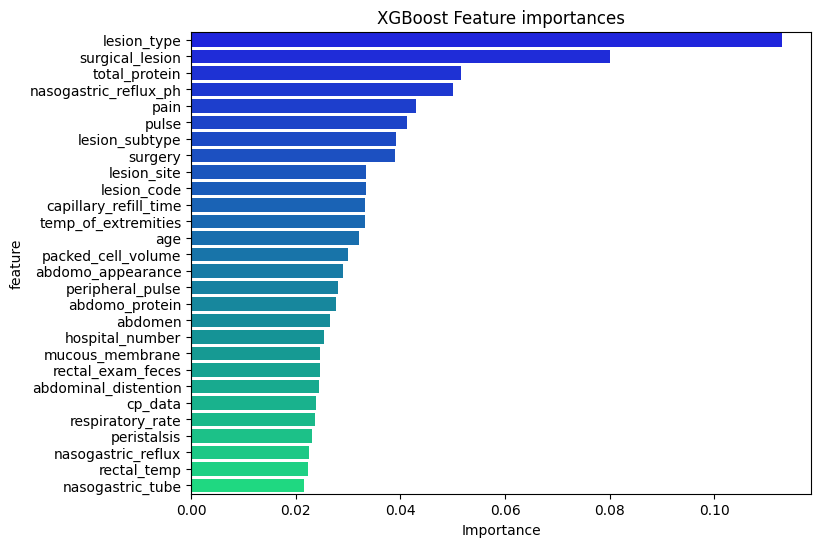

In [ ]:
# Plot feature importances
feature_imp = pd.DataFrame({'feature': X_train.columns, 'Importance': tuned_xgb.feature_importances_})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feature_imp[:30], x='Importance', y='feature', palette='winter')
plt.title("XGBoost Feature importances")
plt.show()

In [ ]:
feature_imp.shape

(28, 2)

In [ ]:
# if more than one evaluation metric are given the last one is used for early stopping
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

# if more than one evaluation metric are given the last one is used for early stopping
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

ValueError: ignored

In [ ]:
train, test = train_test_split(df, test_size=0.2)
train.head()

In [ ]:
X_train = train.loc[:, train.columns != 'outcome']
y_train = train['outcome']

X_test = test.loc[:, test.columns != 'outcome']
y_test = test['outcome']

X_train.head()

In [ ]:
target_map={
    "lived":0,
    "died": 1,
    "euthanized":2
}

classes = np.unique(y_train)  # Get unique class labels
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

print(class_weights)

class_weights_dict = {target_map[cls]: weight for cls, weight in zip(classes, class_weights)}

print("Class counts:", class_counts)
print("Total samples:", total_samples)
print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

In [ ]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, eval_metric="auc")

In [ ]:
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))


In [ ]:
X = df.loc[:, df.columns != 'outcome']
y = df['outcome']
y.head()

In [ ]:
scores = cross_val_score(xgb_model, X, y, scoring="neg_log_loss", cv = StratifiedKFold(shuffle=True, random_state=42))

display_scores(np.sqrt(-scores))

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, eval_metric="auc")
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    scores.append(mean_squared_error(y_test, y_pred))

display_scores(np.sqrt(scores))

In [ ]:
# if more than one evaluation metric are given the last one is used for early stopping
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

In [ ]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

In [ ]:
xgb.plot_importance(xgb_model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)